In [3]:
import pandas as pd
import numpy as np
import re
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import ADASYN


In [4]:
play2024_df = pd.read_csv("data/play_by_play_2024.csv")
injury2024_df = pd.read_csv("data/injuries_2024.csv")

/var/folders/wx/rd0g6p9d7gn424_rsb8_3k240000gn/T/ipykernel_28871/865703963.py:1: DtypeWarning: Columns (179,180,182,183,189,190,197,198,203,204,205,206,222,224,226,233,234,235,236,237,238,253,254,255,260,262,263,283,284) have mixed types. Specify dtype option on import or set low_memory=False.
  play2024_df = pd.read_csv("data/play_by_play_2024.csv")


In [5]:
columns_needed = [
    # "play_id",
    # "game_id",
    "home_team",
    "away_team",
    "season_type",
    # "game_date",
    "down",
    "play_type",
    "score_differential_post",
    # "order_sequence",
    # "time_of_day",
    # "stadium",
    # "weather",
    "roof",
    "surface",
    "temp",
    "wind",
    "was_injured",
    "missed_time"
]

In [6]:
def first_last_a(name):
    parts = name.split(" ", 1)
    return f"{parts[0][0]}.{parts[1]}"

In [7]:
def first_last_b(name):
    parts = name.split(" ", 1)
    return f"{parts[0][0:2]}.{parts[1]}"

In [8]:
warnings.filterwarnings('ignore')

def merge_play_injury_dfs(play_df, injury_df):
    # preprocessing
    injury_df["date"] = pd.to_datetime(injury_df['date_modified'])
    play_df["date"] = pd.to_datetime(play_df['game_date'])
    injury_df['date'] = injury_df['date'].dt.tz_localize(None)
    play_df['date'] = play_df['date'].dt.tz_localize(None)

    # filtering
    plays_with_injuries = play_df[play_df['desc'].str.contains("was injured", na=False)]
    pattern = r'(\w+\.(?:\w|-|\.|\')+(?: \w+)*) was injured'
    # Extract the injured player's name from the desc column
    injured_players = plays_with_injuries.loc[:, "desc"].str.extract(pattern)

    # concatenation
    plays_with_injuries = pd.concat([plays_with_injuries, injured_players], axis=1)
    plays_with_injuries.rename(columns={0: "injured_player"}, inplace=True)
    plays_with_injuries = plays_with_injuries.reset_index(drop=True)
    
    # merging
    injuries = []
    for (week, team), group_injury_df in injury_df.groupby(['week', 'team']):
        group_play_df = plays_with_injuries[(plays_with_injuries['week'] == week) & ((plays_with_injuries['home_team'] == team) | (plays_with_injuries['away_team'] == team))]

        group_injury_df = group_injury_df[group_injury_df.date >= group_play_df.date.max()]

        group_injury_df["first_type"] = group_injury_df['full_name'].apply(first_last_a)
        group_injury_df["second_type"] = group_injury_df['full_name'].apply(first_last_b)

        x = pd.merge(group_play_df, group_injury_df, left_on="injured_player", right_on="first_type", how="inner")
        y = pd.merge(group_play_df, group_injury_df, left_on="injured_player", right_on="second_type", how="inner")

        injuries.append(pd.concat([x, y], axis = 0, ignore_index=True))

    plays_with_injuries_and_injury_record = (pd.concat(injuries, axis=0, ignore_index=True)).drop(columns=["first_type", "second_type"])
    plays_with_injuries_and_injury_record = plays_with_injuries_and_injury_record.sort_values('play_id', ascending=False).drop_duplicates(subset=['week_x', 'full_name', "team"], keep='first')

    return plays_with_injuries, plays_with_injuries_and_injury_record
#returns (plays where injuries occurred, plays were injuries occurred and missed time)



In [9]:
def populate_cols_in_play_df(play_df, plays_with_injuries, plays_with_injuries_and_injury_record):
    columns_to_check = ['play_id', 'game_id']
    play_df["was_injured"] = 0
    play_df["missed_time"] = 0
    play_df.loc[play_df[columns_to_check].apply(tuple, 1).isin(plays_with_injuries[columns_to_check].apply(tuple, 1)), 'was_injured'] = 1
    play_df.loc[play_df[columns_to_check].apply(tuple, 1).isin(plays_with_injuries_and_injury_record[columns_to_check].apply(tuple, 1)), 'missed_time'] = 1

    return play_df

In [10]:
# Step 1: Extract and categorize weather condition
def extract_weather_condition(description):
    if pd.isna(description) or 'N/A' in description:
        return 'Unknown'
    
    description = description.lower()
    
    # Expanded weather condition checks with more keywords
    if any(word in description for word in ['sunny', 'mostly sunny', 'partly sunny', 'sun']):
        return 'Sunny'
    elif any(word in description for word in ['cloudy', 'mostly cloudy', 'partly cloudy', 'overcast']):
        return 'Cloudy'
    elif 'clear' in description:
        return 'Clear'
    elif 'rain' in description or 'rainy' in description:
        return 'Rain'
    elif 'fog' in description or 'foggy' in description:
        return 'Foggy'
    elif 'wind' in description or 'blustery' in description:
        return 'Windy'
    elif 'controlled climate' in description or 'indoors' in description:
        return 'Controlled Climate'
    elif 'fair' in description:
        return 'Fair'
    else:
        return 'Other'

# Apply the improved categorization function
play2024_df['weather_condition'] = play2024_df['weather'].apply(extract_weather_condition)

# Step 2: Extract and categorize temperature
def extract_temperature(description):
    match = re.search(r'Temp: (\d+)', description) if isinstance(description, str) else None
    return int(match.group(1)) if match else np.nan

play2024_df['temperature'] = play2024_df['weather'].apply(extract_temperature)

def categorize_temperature(temp):
    if pd.isna(temp):
        return 'Unknown'
    elif temp < 50:
        return 'Cold'
    elif 50 <= temp <= 75:
        return 'Moderate'
    else:
        return 'Hot'

play2024_df['temperature_category'] = play2024_df['temperature'].apply(categorize_temperature)

# Step 3: Extract and categorize humidity
def extract_humidity(description):
    match = re.search(r'Humidity: (\d+)%', description) if isinstance(description, str) else None
    return int(match.group(1)) if match else np.nan

play2024_df['humidity'] = play2024_df['weather'].apply(extract_humidity)

def categorize_humidity(humidity):
    if pd.isna(humidity):
        return 'Unknown'
    elif humidity < 40:
        return 'Low'
    elif 40 <= humidity <= 70:
        return 'Moderate'
    else:
        return 'High'

play2024_df['humidity_category'] = play2024_df['humidity'].apply(categorize_humidity)

# Step 4: Extract and categorize wind
def extract_wind_speed(description):
    match = re.search(r'Wind: [A-Za-z]* (\d+)', description) if isinstance(description, str) else None
    return int(match.group(1)) if match else np.nan

play2024_df['wind_speed'] = play2024_df['weather'].apply(extract_wind_speed)

def categorize_wind_speed(wind_speed):
    if pd.isna(wind_speed):
        return 'Unknown'
    elif wind_speed < 5:
        return 'Calm'
    elif 5 <= wind_speed <= 15:
        return 'Breezy'
    else:
        return 'Windy'

play2024_df['wind_category'] = play2024_df['wind_speed'].apply(categorize_wind_speed)


In [11]:
plays_with_injuries_2024, plays_with_injuries_and_injury_record_2024 = merge_play_injury_dfs(play2024_df, injury2024_df)


In [12]:
# Print number of rows for each returned table
print("Rows in plays_with_injuries_2024:", len(plays_with_injuries_2024))
print("Rows in plays_with_injuries_and_injury_record_2024:", len(plays_with_injuries_and_injury_record_2024))


Rows in plays_with_injuries_2024: 457
Rows in plays_with_injuries_and_injury_record_2024: 185


In [13]:
play2024_df = populate_cols_in_play_df(play2024_df, plays_with_injuries_2024, plays_with_injuries_and_injury_record_2024)

In [14]:
final_df = play2024_df[[*columns_needed, 'weather_condition', 'temperature', 'humidity_category', 'wind_category']]

In [13]:
print(final_df)

      home_team away_team season_type  down play_type  \
0           BUF       ARI         REG   NaN       NaN   
1           BUF       ARI         REG   NaN   kickoff   
2           BUF       ARI         REG   1.0       run   
3           BUF       ARI         REG   2.0      pass   
4           BUF       ARI         REG   1.0      pass   
...         ...       ...         ...   ...       ...   
26340       LAC       TEN         REG   NaN   no_play   
26341       LAC       TEN         REG   NaN   kickoff   
26342       LAC       TEN         REG   1.0  qb_kneel   
26343       LAC       TEN         REG   2.0  qb_kneel   
26344       LAC       TEN         REG   NaN       NaN   

       score_differential_post      roof     surface  temp  wind  was_injured  \
0                          NaN  outdoors      a_turf  61.0  20.0            0   
1                          0.0  outdoors      a_turf  61.0  20.0            0   
2                          0.0  outdoors      a_turf  61.0  20.0        

In [14]:
print(play2024_df['weather'].unique())

['Clouds and sun with wind Temp: 61° F, Humidity: 55%, Wind: W 20 mph'
 'Temp: 67° F, Humidity: 53%, Wind: NE 8 mph'
 'Cloudy Temp: 75° F, Humidity: 64%, Wind: C 13 mph'
 'Sunny Temp: 68° F, Humidity: 41%, Wind: W 15 mph'
 'Mostly Cloudy Temp: 73° F, Humidity: 72%, Wind: S 7 mph'
 'Temp: 63° F, Humidity: 87%, Wind: SE 4 mph'
 'Mostly sunny Temp: 63° F, Humidity: 41%, Wind: NNE 3 mph'
 'Partly Cloudy Temp: 91° F, Humidity: 57%, Wind: SE 10 mph'
 'Controlled Climate Temp: 68° F, Humidity: 70%, Wind: mph'
 'Sunny Temp: 97° F, Humidity: 27%, Wind: WSW 7 mph'
 'A few clouds Temp: 64° F, Humidity: 48%, Wind: NW 10 mph'
 'Sunny Temp: 66° F, Humidity: 40%, Wind: NNE 5 mph'
 'Sunny Temp: 76° F, Humidity: 60%, Wind: NE 10 mph'
 'Clear Temp: Humidity: Wind: mph'
 'Mostly Sunny Temp: 67° F, Humidity: 43%, Wind: W 8 mph'
 'Cloudy Temp: 93° F, Humidity: 60%, Wind: SW 6 mph'
 'Cloudy Temp: 71° F, Humidity: 72%, Wind: E 9 mph'
 'Partly Cloudy Temp: 86° F, Humidity: 79%, Wind: S 3 mph'
 'Clear Temp: 89

In [15]:
play2024_df[['weather', 'weather_condition', 'temperature', 'temperature_category', 
                   'humidity', 'humidity_category', 'wind_speed', 'wind_category']]

,weather,weather_condition,temperature,temperature_category,humidity,humidity_category,wind_speed,wind_category
0,"Clouds and sun with wind Temp: 61° F, Humidity...",Sunny,61.0,Moderate,55.0,Moderate,20.0,Windy
1,"Clouds and sun with wind Temp: 61° F, Humidity...",Sunny,61.0,Moderate,55.0,Moderate,20.0,Windy
2,"Clouds and sun with wind Temp: 61° F, Humidity...",Sunny,61.0,Moderate,55.0,Moderate,20.0,Windy
3,"Clouds and sun with wind Temp: 61° F, Humidity...",Sunny,61.0,Moderate,55.0,Moderate,20.0,Windy
4,"Clouds and sun with wind Temp: 61° F, Humidity...",Sunny,61.0,Moderate,55.0,Moderate,20.0,Windy
...,...,...,...,...,...,...,...,...
26340,"Sunny Temp: 73° F, Humidity: 36%, Wind: SW 6 mph",Sunny,73.0,Moderate,36.0,Low,6.0,Breezy
26341,"Sunny Temp: 73° F, Humidity: 36%, Wind: SW 6 mph",Sunny,73.0,Moderate,36.0,Low,6.0,Breezy
26342,"Sunny Temp: 73° F, Humidity: 36%, Wind: SW 6 mph",Sunny,73.0,Moderate,36.0,Low,6.0,Breezy
26343,"Sunny Temp: 73° F, Humidity: 36%, Wind: SW 6 mph",Sunny,73.0,Moderate,36.0,Low,6.0,Breezy


In [16]:
play2024_df['weather_condition'].value_counts()

weather_condition
Sunny      9026
Cloudy     8143
Windy      3819
Clear      2260
Unknown    2232
Rain        692
Foggy       173
Name: count, dtype: int64

In [17]:
print(final_df.columns)

Index(['home_team', 'away_team', 'season_type', 'down', 'play_type',
       'score_differential_post', 'roof', 'surface', 'temp', 'wind',
       'was_injured', 'missed_time', 'weather_condition', 'temperature',
       'humidity_category', 'wind_category'],
      dtype='object')


# Constructing the RNN

## Feature selection

In [18]:
# Split the data
X = final_df.drop(['was_injured', 'missed_time'], axis=1)
y = final_df['was_injured']

In [19]:
# Encode categorical variables
X = pd.get_dummies(X, drop_first=True)
X = X.fillna(0) 

In [20]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [21]:
# Train a Random Forest
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [22]:
# Feature importance
importances = rf.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

                    Feature  Importance
1   score_differential_post    0.253270
0                      down    0.176357
4               temperature    0.047450
2                      temp    0.035269
74            play_type_run    0.033676
..                      ...         ...
14            home_team_DET    0.001823
93      wind_category_Windy    0.001778
12            home_team_DAL    0.001750
83  weather_condition_Foggy    0.001180
73       play_type_qb_spike    0.000591

[94 rows x 2 columns]


## RNN

In [23]:
import torch
from torch.utils.data import DataLoader, TensorDataset

In [24]:
# Convert the data into sequences
def create_sequences(data, target, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        label = target[i + sequence_length]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

In [25]:
from sklearn.utils import resample

# Combine features (X) and labels (y) into a single DataFrame for easier handling
data = pd.DataFrame(X)
data['target'] = y

# Separate majority and minority classes
majority = data[data['target'] == 0]
minority = data[data['target'] == 1]

# Perform oversampling on the minority class
minority_oversampled = resample(minority, 
                                replace=True,  # Allow sampling with replacement
                                n_samples=len(majority),  # Match the size of the majority class
                                random_state=42)

# Combine majority class and oversampled minority class
balanced_data = pd.concat([majority, minority_oversampled])

# Separate the oversampled data back into features and labels
X_balanced = balanced_data.drop('target', axis=1).values
y_balanced = balanced_data['target'].values

# Convert everything to float for consistency
X_balanced = X_balanced.astype(float)
y_balanced = y_balanced.astype(float)

In [26]:
# Define sequence length
sequence_length = 10
X = X.astype(float)  # Convert everything to float for consistency
X_sequences, y_sequences = create_sequences(X_balanced, y_balanced, sequence_length)

In [27]:
# Convert to PyTorch tensors
X_sequences = torch.tensor(X_sequences, dtype=torch.float32)
y_sequences = torch.tensor(y_sequences, dtype=torch.float32)

In [28]:
# Create DataLoader for batch processing
dataset = TensorDataset(X_sequences, y_sequences)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [29]:
import torch.nn as nn

class InjuryRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(InjuryRNN, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(p=0.5)  # Dropout layer
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # LSTM output: (batch_size, seq_length, hidden_size)
        lstm_out, _ = self.lstm(x)
        # Only take the output of the last time step
        last_out = lstm_out[:, -1, :]
        out = self.dropout(last_out)
        out = self.fc(out)
        out = self.sigmoid(out)
        return out


In [30]:
input_size = X_sequences.shape[2]
hidden_size = 64
output_size = 1
num_layers = 1

model = InjuryRNN(input_size, hidden_size, output_size, num_layers)
# Calculate class weights
pos_weight = torch.tensor([len(y) / sum(y)])  # Adjust based on class imbalance ratio
# Define loss function with class weights
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [31]:
# Train the model
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/20, Loss: 9.7600
Epoch 2/20, Loss: 9.5989
Epoch 3/20, Loss: 9.5941
Epoch 4/20, Loss: 9.5939
Epoch 5/20, Loss: 9.5854
Epoch 6/20, Loss: 9.5898
Epoch 7/20, Loss: 9.5877
Epoch 8/20, Loss: 9.5853
Epoch 9/20, Loss: 9.5840
Epoch 10/20, Loss: 9.5805
Epoch 11/20, Loss: 9.5457
Epoch 12/20, Loss: 9.5118
Epoch 13/20, Loss: 9.4634
Epoch 14/20, Loss: 9.4466
Epoch 15/20, Loss: 9.4175
Epoch 16/20, Loss: 9.4196
Epoch 17/20, Loss: 9.4218
Epoch 18/20, Loss: 9.4135
Epoch 19/20, Loss: 9.4165
Epoch 20/20, Loss: 9.4107


In [32]:
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        y_pred.extend(outputs.squeeze().tolist())
        y_true.extend(y_batch.tolist())

# Convert predictions to binary values
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]


In [33]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_true, y_pred_binary))
print(f"AUC-ROC: {roc_auc_score(y_true, y_pred):.4f}")


              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      5197
         1.0       0.99      1.00      1.00      5157

    accuracy                           1.00     10354
   macro avg       1.00      1.00      1.00     10354
weighted avg       1.00      1.00      1.00     10354

AUC-ROC: 0.9996


## Testing with unbalanced data

In [34]:
# Define sequence length
sequence_length = 10
X = X.astype(float)  # Convert everything to float for consistency
X_raw_sequences, y_raw_sequences = create_sequences(X.values, y.values, sequence_length)

In [35]:
# Convert to PyTorch tensors
X_raw_sequences = torch.tensor(X_raw_sequences, dtype=torch.float32)
y_raw_sequences = torch.tensor(y_raw_sequences, dtype=torch.float32)

In [36]:
# Create DataLoader for batch processing
raw_dataset = TensorDataset(X_raw_sequences, y_raw_sequences)
raw_test_size = len(raw_dataset) - int(0.8 * len(raw_dataset))
_, raw_test_dataset = torch.utils.data.random_split(raw_dataset, [int(0.8 * len(raw_dataset)), raw_test_size])

raw_test_loader = DataLoader(raw_test_dataset, batch_size=32, shuffle=False)

In [37]:
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in raw_test_loader:
        outputs = model(X_batch)
        y_pred.extend(outputs.squeeze().tolist())
        y_true.extend(y_batch.tolist())

# Convert predictions to binary values
y_pred_binary = [1 if pred > 0.00001 else 0 for pred in y_pred]


In [38]:
print(np.where(np.array(y_true) == 1))

(array([   3,   51,  146,  156,  199,  217,  235,  281,  383,  394,  488,
        722,  732,  737,  750,  776,  827,  848,  899,  971,  994, 1009,
       1127, 1239, 1392, 1456, 1477, 1483, 1525, 1549, 1605, 1610, 1622,
       1635, 1640, 1684, 1704, 1765, 1767, 1804, 1811, 1931, 2046, 2085,
       2086, 2130, 2137, 2161, 2365, 2423, 2429, 2595, 2646, 2660, 2757,
       2872, 2997, 3035, 3036, 3043, 3057, 3059, 3105, 3171, 3302, 3307,
       3318, 3386, 3399, 3403, 3411, 3425, 3550, 3666, 3723, 3796, 4113,
       4138, 4170, 4212, 4220, 4262, 4342, 4379, 4382, 4417, 4504, 4628,
       4658, 4726, 4906, 4930, 4971, 4982, 5023, 5059]),)


In [39]:
value_counts = pd.Series(y_true).value_counts()

In [40]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_true, y_pred_binary))
print(f"AUC-ROC: {roc_auc_score(y_true, y_pred):.4f}")

              precision    recall  f1-score   support

         0.0       0.98      0.20      0.33      5171
         1.0       0.02      0.80      0.04        96

    accuracy                           0.21      5267
   macro avg       0.50      0.50      0.18      5267
weighted avg       0.96      0.21      0.32      5267

AUC-ROC: 0.4452


## Trying something else

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import numpy as np

In [15]:
# Assuming 'X' and 'y' are your feature matrix and target variable
X_df = final_df.drop(columns=["was_injured", "missed_time"])

# Encode categorical variables
X_encoded = pd.get_dummies(X_df, drop_first=True)
X_encoded = X_encoded.fillna(0) 

X = X_encoded.astype(np.float32)
X = X.values

y = final_df["was_injured"].values

In [16]:
print(X_encoded.shape)

(26345, 94)


In [17]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

# Apply SMOTE for oversampling the minority class
smote = SMOTE(sampling_strategy="minority", random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Convert to PyTorch tensors and reshape for RNN input
X_train_smote = torch.tensor(X_train_smote, dtype=torch.float32).unsqueeze(1)  # (batch_size, seq_len, features)
y_train_smote = torch.tensor(y_train_smote, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [18]:
# Define the RNN model
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNNClassifier, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='relu')
        # self.gru = nn.(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)  # Initial hidden state
        out, _ = self.rnn(x, h0)
        # out, _ = self.gru(x)
        out = self.dropout(out[:, -1, :])  # Take the last time step
        out = self.fc(out)
        return self.sigmoid(out)

In [23]:
# Define the GRU model
class GRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(GRUClassifier, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)  # Initial hidden state
        out, _ = self.gru(x)
        out = self.dropout(out[:, -1, :])  # Take the last time step
        out = self.fc(out)
        return self.sigmoid(out)

In [19]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class TransformerClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_heads):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Linear(input_size, hidden_size)
        encoder_layers = TransformerEncoderLayer(hidden_size, num_heads, hidden_size * 2)
        self.transformer = TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        x = self.fc(x[:, 0, :])  # Use the first token for classification
        return self.sigmoid(x)

In [20]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take output of last time step
        return self.sigmoid(out)


In [21]:
# Hyperparameters
input_size = X_train_smote.shape[2]
hidden_size = 64
num_layers = 2
learning_rate = 0.001
num_epochs = 50
batch_size = 32

In [24]:
# Model, loss, and optimizer
model = GRUClassifier(input_size, hidden_size, num_layers)

In [25]:
# Define weighted binary cross-entropy loss
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

In [26]:
# Use weighted loss
criterion = nn.BCELoss(reduction='none')  # Use reduction='none' for element-wise loss

In [27]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [28]:
# DataLoader
train_data = torch.utils.data.TensorDataset(X_train_smote, y_train_smote)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [29]:
# Training loop
model.train()
for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)

        weights = class_weights[y_batch.long()]  # Extract weights for the batch
        loss = (loss * weights).mean()  # Weighted mean loss
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [10/50], Loss: 0.0569
Epoch [20/50], Loss: 0.4319
Epoch [30/50], Loss: 0.3826
Epoch [40/50], Loss: 0.0308
Epoch [50/50], Loss: 0.2561


In [30]:
# Evaluation
model.eval()
with torch.no_grad():
    y_pred_proba = model(X_test).squeeze().numpy()
    y_pred = (y_pred_proba >= 0.5).astype(int)

In [31]:
# Compute metrics
if type(y_test) is not np.ndarray:
    y_test = y_test.numpy()
accuracy = np.mean(y_pred == y_test)
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(conf_matrix)

# Save metrics to a JSON file
import json

metrics = {
    "accuracy": accuracy,
    "precision": report["weighted avg"]["precision"],
    "recall": report["weighted avg"]["recall"],
    "f1_score": report["weighted avg"]["f1-score"],
    "roc_auc": roc_auc,
    "confusion_matrix": conf_matrix.tolist()
}

with open("rnn_metrics.json", "w") as f:
    json.dump(metrics, f)

Accuracy: 0.70
ROC AUC: 0.59
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.71      0.82      2589
         1.0       0.02      0.35      0.04        46

    accuracy                           0.70      2635
   macro avg       0.50      0.53      0.43      2635
weighted avg       0.97      0.70      0.81      2635

Confusion Matrix:
[[1827  762]
 [  30   16]]


Confusion Matrix:
[[1827  762]
 [  30   16]]


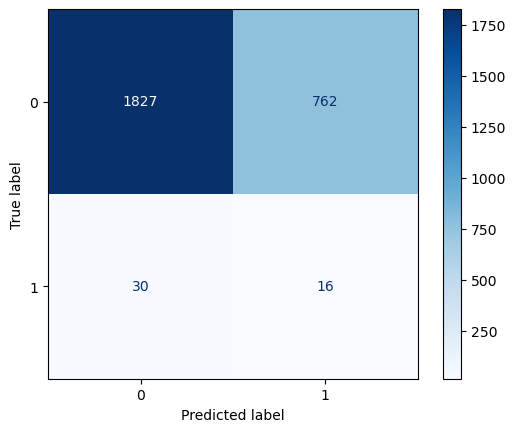

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")  # You can customize the color map if needed

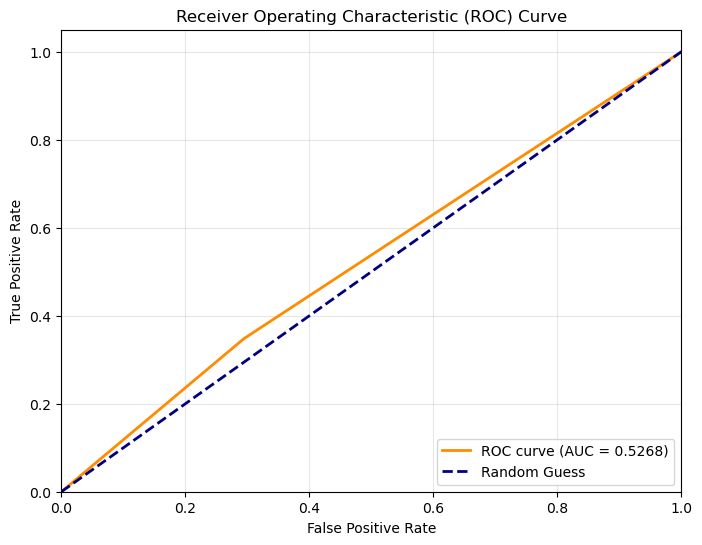

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Ensure y_true and y_pred are NumPy arrays
y_test = np.array(y_test)  # Replace with your true labels
y_pred = np.array(y_pred)  # Replace with your predicted probabilities

# Calculate the False Positive Rate (FPR), True Positive Rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


In [34]:
# Assuming you used a DataFrame for your input
feature_names = list(X_encoded.columns)  # Replace with your feature names

In [36]:
# Extract weights from the LSTM and fully connected layers
lstm_weights = model.gru.weight_ih_l0.detach().cpu().numpy()  # Input-to-hidden weights of the first LSTM layer
fc_weights = model.fc.weight.detach().cpu().numpy()           # Fully connected layer weights


In [37]:
import pandas as pd

hidden_size = model.gru.hidden_size
input_size = model.gru.input_size

# Adjust feature_names if necessary
if len(feature_names) > input_size:
    feature_names = feature_names[:input_size]  # Truncate extra names
elif len(feature_names) < input_size:
    feature_names += [f"Feature_{i}" for i in range(len(feature_names), input_size)]  # Add placeholders


# Reshape LSTM weights for the gates
input_gate_weights = lstm_weights[:hidden_size, :]  # First hidden_size rows
forget_gate_weights = lstm_weights[hidden_size:2*hidden_size, :]
cell_gate_weights = lstm_weights[2*hidden_size:3*hidden_size, :]
output_gate_weights = lstm_weights[3*hidden_size:, :]

# Create DataFrames to map feature names
input_gate_df = pd.DataFrame(input_gate_weights, columns=feature_names)
forget_gate_df = pd.DataFrame(forget_gate_weights, columns=feature_names)
cell_gate_df = pd.DataFrame(cell_gate_weights, columns=feature_names)
output_gate_df = pd.DataFrame(output_gate_weights, columns=feature_names)

# Example: Analyze the importance of features in the input gate
print("Input Gate Feature Importance:")
print(input_gate_df.abs().mean(axis=0).sort_values(ascending=False)[:20])  # Mean absolute weight per feature


Input Gate Feature Importance:
away_team_TB         1.042623
away_team_LA         0.986806
away_team_DAL        0.919526
play_type_punt       0.862276
away_team_PHI        0.859751
away_team_WAS        0.791060
away_team_DEN        0.714606
away_team_BAL        0.703593
away_team_PIT        0.693735
play_type_kickoff    0.678816
play_type_run        0.667984
home_team_MIN        0.648129
away_team_LAC        0.647438
play_type_no_play    0.646771
play_type_pass       0.605151
away_team_DET        0.602339
away_team_HOU        0.597220
away_team_BUF        0.592836
away_team_IND        0.591271
away_team_NYJ        0.571919
dtype: float32
